# example3 — Spectral sweep of Rd(λ) for the skin–vessel geometry

This notebook performs a **wavelength sweep** for the same skin–blood-vessel geometry, building tissue optical properties at each wavelength, running NMC/MCXYZ, and extracting the **diffuse reflectance spectrum** R<sub>d</sub>(λ).

**Workflow**

1. Define the working directory (`nmcdir`), base case name (`myname = "skinvessel"`), run time, and the wavelength array `nm_values` (e.g. 350–750 nm).  
2. For each wavelength λ:  
   a. Build tissue optical properties μ<sub>a</sub>, μ<sub>s</sub>, g via `tissue_parameters(nm)`.  
   b. Set up the 3D grid and skin–vessel geometry `T(y,x,z)` (epidermis, dermis, blood vessel cylinder, etc.).  
   c. Write the geometry file `<myname>_<λ>nm_T.bin` and the corresponding run-control file `<myname>_<λ>nm_H.mci`, including n₁, n₂, NA, coherence length, and kernel flags.  
3. (Optional) For each λ, run the external NMC binary `./nmc <myname>_<λ>nm` to generate `<myname>_<λ>nm_Rd.dat` and other output files (if the binary is present).  
4. Read `R_d` from `<run_name>_Rd.dat` for each wavelength and accumulate `(λ, R_d)` into `rd_results`.  
5. Save the resulting spectrum as a text file and plot **diffuse reflectance vs wavelength** R<sub>d</sub>(λ), exporting the figure as `<myname>_diffuse_reflectance_vs_wavelength_nm.png`.

> If the NMC binary is missing, the notebook still constructs all input files but skips the MC execution, leaving `R_d` values as NaN.


In [1]:
import numpy as np
import os,subprocess
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.io import loadmat
from pathlib import Path
import struct
from tqdm import tqdm
import math

In [2]:
nmcdir = Path('../NMC/DerivedData/NMC/Build/Products/Release')
spectralLIB_dir = os.getcwd()
# Use nmcdir if it exists; otherwise stay in current dir to avoid errors.
if nmcdir.exists():
    os.chdir(nmcdir)
print('Working directory:', Path.cwd())

def tissue_parameters(nm, spectral_lib_file: str = "spectralLIB.mat"):
    """
    Returns a dict of tissue optical properties at wavelength nm (in nm).
    Each tissue has keys: 'name', 'mua', 'mus', 'g', 'musp'.
    """

    # --- Load spectral library ---
    spectral_lib_path = os.path.join(spectralLIB_dir, spectral_lib_file)
    print('Spectral library path:', spectral_lib_path)
    data = loadmat(spectral_lib_path)
    muaoxy   = data["muaoxy"].ravel()
    muadeoxy = data["muadeoxy"].ravel()
    muawater = data["muawater"].ravel()
    muamel   = data["muamel"].ravel()
    nmLIB    = data["nmLIB"].ravel().astype(float)

    # Interpolate spectra at nm
    MU = np.zeros(4)
    MU[0] = np.interp(nm, nmLIB, muaoxy)    # oxy-Hb
    MU[1] = np.interp(nm, nmLIB, muadeoxy)  # deoxy-Hb
    MU[2] = np.interp(nm, nmLIB, muawater)  # water
    MU[3] = np.interp(nm, nmLIB, muamel)    # melanin

    def musp_at(musp500, fray, bmie):
        """scattering at nm"""
        x = nm / 500.0
        return musp500 * (fray * x**-4 + (1 - fray) * x**-bmie)

    def mua_mix(B, S, W, M):
        """absorption mix"""
        X = np.array([B * S, B * (1 - S), W, M], dtype=float)
        return float(MU @ X)

    tissue_list = {}

    # 1) Air
    tissue_list[1] = {"name": "air", "mua": 1e-4, "mus": 1.0, "g": 1.0}
    tissue_list[1]["musp"] = tissue_list[1]["mus"] * (1 - tissue_list[1]["g"])

    # 2) Water
    tissue_list[2] = {"name": "water", "mua": MU[2], "mus": 10.0, "g": 1.0}
    tissue_list[2]["musp"] = tissue_list[2]["mus"] * (1 - tissue_list[2]["g"])

    # 3) Blood
    B, S, W, M = 1.00, 0.75, 0.95, 0.0
    musp500, fray, bmie, gg = 10.0, 0.0, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[3] = {
        "name": "blood",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 4) Dermis
    B, S, W, M = 0.002, 0.67, 0.65, 0.0
    musp500, fray, bmie, gg = 43.6, 0.41, 0.562, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[4] = {
        "name": "dermis",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 5) Epidermis
    B, S, W, M = 0.0, 0.75, 0.75, 0.03
    musp500, fray, bmie, gg = 66.7, 0.29, 0.689, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[5] = {
        "name": "epidermis",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 6) Skull
    B, S, W, M = 0.0005, 0.75, 0.35, 0.0
    musp500, fray, bmie, gg = 30.0, 0.0, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[6] = {
        "name": "skull",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 7) Gray matter
    B, S, W, M = 0.01, 0.75, 0.75, 0.0
    musp500, fray, bmie, gg = 20.0, 0.2, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[7] = {
        "name": "gray matter",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 8) White matter
    B, S, W, M = 0.01, 0.75, 0.75, 0.0
    musp500, fray, bmie, gg = 20.0, 0.2, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[8] = {
        "name": "white matter",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 9) Standard tissue
    tissue_list[9] = {"name": "standard tissue", "mua": 1.0, "mus": 100.0, "g": 0.90}
    tissue_list[9]["musp"] = tissue_list[9]["mus"] * (1 - tissue_list[9]["g"])

    return tissue_list


Working directory: /Users/aledoronin/Desktop/NMC_framework/NMC/DerivedData/NMC/Build/Products/Release


In [3]:
# --- assumes tissue_parameters(nm) is defined (the nm-only version from earlier) ---
# from your_module import tissue_parameters

# =========================
# User-defined / from your config
# =========================
SAVEON       = 1
myname       = "skinvessel"
time_min     = 10.0
nm           = 532
lambda_mm    = 532.0e-6;

# Wavelength sweep: 350–750 nm, step size 20
nm_values = np.arange(350, 751, 20)   # array of wavelengths in nm
lambda_mm_values = nm_values * 1e-6   # convert to mm

print("Wavelengths (nm):", nm_values)


lc           = 0.001; 
n1           = 1.4
n2           = 1.001

Nbins        = 200
binsize      = 0.0005   # be consistent with your kernel units

# Launch / boundary flags
mckernelflag = 1  # 1=mcxyz
det_state    = 0  # 0-reflectance, 1-transmittance
mcflag       = 0        # 0=uniform, 1=Gaussian, 2=isotropic point, 3=rectangular
launchflag   = 0        # 0=auto launch vector, 1=manual ux0,uy0,uz0
boundaryflag = 2        # 0=no boundaries, 1=escape at boundaries, 2=escape at surface only
zsurf        = 0.0100   # air/skin interface depth
speckleflag  = 0
semiflag     = 1

# Source / focus geometry
xs, ys, zs   = 0.0, 0.0, 0.0101
xfocus, yfocus = 0.0, 0.0
zfocus       = math.inf  # inf -> collimated

# Beam radii (if mcflag in {0,1,3})
radius       = 0.0300
waist        = 0.0300
det_radius   = 15.0;
separation   = 0.0; 
na           = 90.0  # numerical aperture (deg ~ 90 collects all reflectance)
    
# Manual launch vector (if launchflag == 1)
ux0, uy0 = 0.7, 0.4
uz0      = math.sqrt(max(0.0, 1.0 - ux0**2 - uy0**2))


Wavelengths (nm): [350 370 390 410 430 450 470 490 510 530 550 570 590 610 630 650 670 690
 710 730 750]


Spectral library path: /Users/aledoronin/Desktop/NMC_framework/NMC-samples/spectralLIB.mat
Tissue library Nt=9 | grid 200x200x200 @ 0.0005 units
x∈[-0.0495,0.0500], z∈[0.0005,0.1000] | zsurf=0.0100
Vessel radius=0.0100 at (x=0.0000, z=0.0500)


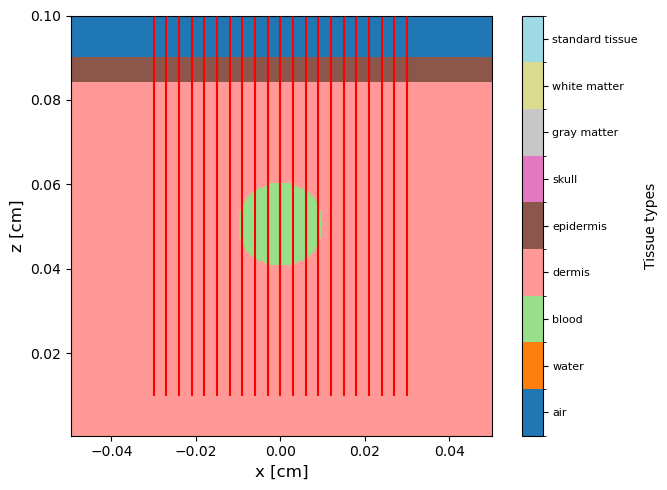

In [4]:
# =========================
# Grid and coordinate axes
# =========================
Nx = Ny = Nz = int(Nbins)
dx = dy = dz = float(binsize)

x = (np.arange(1, Nx + 1) - Nx / 2.0) * dx  # center at 0 in x
y = (np.arange(1, Ny + 1) - Ny / 2.0) * dy  # center at 0 in y
z = (np.arange(1, Nz + 1)) * dz             # z starts positive downward

zmin, zmax = float(z.min()), float(z.max())
xmin, xmax = float(x.min()), float(x.max())

# Replace inf focus for file writing compatibility
zfocus_out = 1e12 if math.isinf(zfocus) else float(zfocus)

# =========================
# Build tissue label volume T(y, x, z)
# =========================
# Convention: indices in your tissue list:
# 2 = water/air (you used 2 for "air" in MATLAB)
# 4 = dermis (background)
# 5 = epidermis
# 3 = blood
# Match exactly your MATLAB labeling.
AIR_IDX      = 1
DERMIS_IDX   = 4
EPIDERMIS_IDX= 5
BLOOD_IDX    = 3

T = np.zeros((Ny, Nx, Nz), dtype=np.float64)

# Fill background with dermis
T[...] = DERMIS_IDX

# Air above surface
air_z_limit = int(round(zsurf / dz))
if air_z_limit >= 1:
    T[:, :, :air_z_limit] = AIR_IDX

# Epidermis: 60 μm thick (0.006 cm) starting just below zsurf
epi_z1 = int(round(zsurf / dz))
epi_z2 = int(round((zsurf + 0.0060) / dz))
epi_z1 = max(epi_z1 + 1, 1) 
epi_z2 = min(epi_z2, Nz)
if epi_z2 >= epi_z1:
    T[:, :, epi_z1 - 1:epi_z2] = EPIDERMIS_IDX

# Blood vessel cylinder along y, centered at (xc, zc), radius in x–z plane
xc = 0.0
zc = Nz / 2.0 * dz
vesselradius = 0.0100  # 100 μm

# Precompute x, z distances for speed
X, Z = np.meshgrid(x, z, indexing="xy")  # X: (Nx, Nz), Z: (Nx, Nz)
r = np.sqrt((X - xc) ** 2 + (Z - zc) ** 2)  # (Nx, Nz)
mask_xz = (r <= vesselradius)  # True where inside cylinder

# Paint blood into all y for masked x–z columns
for iz in range(Nz):
    # vectorized over x, set entire y-column for those x that satisfy mask
    x_mask = mask_xz[:, iz]
    if np.any(x_mask):
        T[:, x_mask, iz] = BLOOD_IDX

# =========================
# Visualization
# =========================
def makecmap_py(Nt: int):
    if Nt <= 20:
        base = colormaps.get_cmap('tab20').resampled(Nt)
        colors = base.colors[:Nt]
    else:
        base = colormaps.get_cmap('viridis').resampled(Nt)
        colors = base.colors
    return ListedColormap(colors)

# Extract central slice (iy = Ny/2)
Txzy = np.moveaxis(T, 0, -1)          # (Nx,Nz,Ny)
iy_center = int(round(Ny/2)) - 1
Tzx = Txzy[:, :, iy_center].T

plt.figure(1, figsize=(7, 5))
plt.clf()

# =========================
# Create tissue optical properties (vectors muav, musv, gv)
# =========================
tp = tissue_parameters(nm)  # dict: 1..9

# Build vectors in index order 1..Nt where Nt = len(tp)
indices = sorted(tp.keys())
Nt = len(indices)

cmap = makecmap_py(Nt)
bounds = np.arange(0.5, Nt + 1.5, 1)       # centers 1..Nt
norm = BoundaryNorm(bounds, cmap.N)

im = plt.imshow(
    Tzx,
    extent=[xmin, xmax, zmin, zmax],
    origin='upper',
    aspect='equal',
    cmap=cmap,
    norm=norm,
    interpolation='nearest'
)
plt.xlabel('x [cm]', fontsize=12)
plt.ylabel('z [cm]', fontsize=12)

# Colorbar: ticks are the actual integer tissue IDs; labels are names
cb = plt.colorbar(im, boundaries=bounds, ticks=indices)
cb.ax.tick_params(labelsize=8)
tissue_names = [tp[k].get("name", f"type {k}") for k in indices]
cb.set_ticklabels(tissue_names)
cb.set_label('Tissue types', fontsize=10)

plt.xlim([xmin, xmax])
plt.ylim([zmin, zmax])

# Draw launch rays (N=20)  **unchanged**
N = 20
if mcflag == 0:  # uniform
    for i in range(N + 1):
        xx = -radius + 2 * radius * i / N
        plt.plot([xx, xx], [zs, float(z.max())], 'r-')
elif mcflag == 1:  # Gaussian
    for i in range(N + 1):
        xx = -radius + 2 * radius * i / N
        plt.plot([xx, float(xfocus)], [zs, zfocus_out], 'r-')
elif mcflag == 2:  # isotropic point
    Rdraw = (Nx / 2) * (x[1] - x[0])
    for i in range(1, N + 1):
        th = (i - 1) / (N - 1) * 2 * np.pi
        xx = xs + Rdraw * np.cos(th)
        zz = zs + Rdraw * np.sin(th)
        plt.plot([xs, xx], [zs, zz], 'r-')
elif mcflag == 3:  # rectangular
    zzmax = float(z.max())
    for i in range(1, N + 1):
        xx = -radius + 2 * radius * i / 20.0
        plt.plot([xx, xx], [zs, zzmax], 'r-')

plt.tight_layout()

# Optional: quick console summary
print(f"Tissue library Nt={Nt} | grid {Nx}x{Ny}x{Nz} @ {dx} units")
print(f"x∈[{xmin:.4f},{xmax:.4f}], z∈[{zmin:.4f},{zmax:.4f}] | zsurf={zsurf:.4f}")
print(f"Vessel radius={vesselradius:.4f} at (x={xc:.4f}, z={zc:.4f})")


In [5]:
# Spectra
rd_results = []

# Use nmcdir if it exists; otherwise stay in current dir to avoid errors.
if nmcdir.exists():
    os.chdir(nmcdir)
print('Working directory:', Path.cwd())

for nm in nm_values:
    lambda_mm = nm * 1e-6
    run_name = f"{myname}_{nm}nm"
    
    # =========================
    # Create tissue optical properties (vectors muav, musv, gv)
    # =========================
    tp = tissue_parameters(nm)  # dict: 1..9

    # Build vectors in index order 1..Nt where Nt = len(tp)
    indices = sorted(tp.keys())
    Nt = len(indices)

    muav = np.zeros(Nt, dtype=float)
    musv = np.zeros(Nt, dtype=float)
    gv   = np.zeros(Nt, dtype=float)

    for i, k in enumerate(indices):
        muav[i] = float(tp[k]["mua"])
        musv[i] = float(tp[k]["mus"])
        # write zeros for g unless USE_G is True
        gv[i]   = float(tp[k]["g"])
        
    print(f"\n=== Optical properties at {nm} nm ===")
    print("ID |   mu_a   |   mu_s   |   g   |  g_f  |  a_f  |  g_b  |  a_b  |  C_C")
    print("------------------------------------------------------------------------")
    for i in range(Nt):
        print(f"{i:2d} | {muav[i]:7.4f} | {musv[i]:7.4f} | {gv[i]:5.3f} | "
              f"{0.0:5.3f} | {1.0:5.3f} | {0.0:5.3f} | {0.0:5.3f} | {0.0:5.3f}")

    # --- Write _H.mci ---
    filename = f'{run_name}_H.mci'
    with open(filename, 'w') as fid:
        # run parameters
        fid.write(f"{time_min:.2f}\n")
        fid.write(f"{Nx}\n{Ny}\n{Nz}\n")
        fid.write(f"{dx:.4f}\n{dy:.4f}\n{dz:.4f}\n")
        # launch parameters
        fid.write(f"{mcflag}\n{launchflag}\n{boundaryflag}\n")
        fid.write(f"{xs:.4f}\n{ys:.4f}\n{zs:.4f}\n")
        fid.write(f"{xfocus:.4f}\n{yfocus:.4f}\n{zfocus:.4f}\n")
        fid.write(f"{ux0:.4f}\n{uy0:.4f}\n{uz0:.4f}\n")
        fid.write(f"{radius:.4f}\n{waist:.4f}\n{zsurf:.4f}\n")
        fid.write(f"{det_radius:.4f}\n{separation:.4f}\n")
        fid.write(f"{n1:.4f}\n{n2:.4f}\n")     # NEW in your MATLAB comments
        fid.write(f"{na:.4f}\n{lambda_mm:.4f}\n{lc:.4f}\n")
        fid.write(f"{speckleflag}\n{semiflag}\n{det_state}\n{mckernelflag}\n")
        # tissue optical properties
        fid.write(f"{Nt}\n")
        for i in range(Nt):
            fid.write(f"{muav[i]:.4f}\n{musv[i]:.4f}\n")
            if mckernelflag < 2:
                fid.write(f"{gv[i]:.4f}\n")
            else:
                fid.write(f"{gfv[i]:.4f}\n{afv[i]:.4f}\n{gbv[i]:.4f}\n{abv[i]:.4f}\n{CCv[i]:.4f}\n")
    print('Wrote', filename)

    # --- Write T.bin ---
    tbin = f'{run_name}_T.bin'
    with open(tbin, 'wb') as f:
        f.write(T.ravel(order='F').astype(np.uint8).tobytes())
    print('Wrote', tbin)

    # --- Run MC ---
    rd_val = np.nan
    if Path('./nmc').exists():
        subprocess.run(['./nmc', run_name], capture_output=True, text=True)
        rd_path = Path(f'{run_name}_Rd.dat')
        if rd_path.exists():
            rd_val = float(np.loadtxt(rd_path).reshape(-1)[0])
            print(f'Rd (MC) @ {nm} nm:', rd_val)
    else:
        print('No ./nmc binary found; skipping MC run.')
    rd_results.append((nm, rd_val))

# Save nm vs Rd
rd_results = np.array(rd_results)
np.savetxt(f"{myname}_spectra.csv", rd_results, delimiter=",", header="nm,Rd", comments='')
print("Saved ->", f"{myname}_spectra.csv")

Working directory: /Users/aledoronin/Desktop/NMC_framework/NMC/DerivedData/NMC/Build/Products/Release
Spectral library path: /Users/aledoronin/Desktop/NMC_framework/NMC-samples/spectralLIB.mat

=== Optical properties at 350 nm ===
ID |   mu_a   |   mu_s   |   g   |  g_f  |  a_f  |  g_b  |  a_b  |  C_C
------------------------------------------------------------------------
 0 |  0.0001 |  1.0000 | 1.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 1 |  0.0023 | 10.0000 | 1.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 2 | 591.4721 | 142.8571 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 3 |  1.1977 | 1058.8586 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 4 | 66.8233 | 1411.1192 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 5 |  0.2966 | 428.5714 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 6 |  5.9164 | 395.1687 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 7 |  5.9164 | 395.1687 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 8 |  1.0000 | 100.0000 | 0.900 | 0.000 | 1.000

Rd (MC) @ 510 nm: 0.2878
Spectral library path: /Users/aledoronin/Desktop/NMC_framework/NMC-samples/spectralLIB.mat

=== Optical properties at 530 nm ===
ID |   mu_a   |   mu_s   |   g   |  g_f  |  a_f  |  g_b  |  a_b  |  C_C
------------------------------------------------------------------------
 0 |  0.0001 |  1.0000 | 1.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 1 |  0.0003 | 10.0000 | 1.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 2 | 212.7308 | 94.3396 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 3 |  0.4249 | 390.5472 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 4 | 16.7815 | 608.1487 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 5 |  0.1065 | 283.0189 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 6 |  2.1276 | 182.6271 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 7 |  2.1276 | 182.6271 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 8 |  1.0000 | 100.0000 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
Wrote skinvessel_530nm_H.mci
Wrote skinvessel_530nm_T.b

Rd (MC) @ 690 nm: 0.6182
Spectral library path: /Users/aledoronin/Desktop/NMC_framework/NMC-samples/spectralLIB.mat

=== Optical properties at 710 nm ===
ID |   mu_a   |   mu_s   |   g   |  g_f  |  a_f  |  g_b  |  a_b  |  C_C
------------------------------------------------------------------------
 0 |  0.0001 |  1.0000 | 1.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 1 |  0.0100 | 10.0000 | 1.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 2 |  3.3328 | 70.4225 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 3 |  0.0142 | 255.1945 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 4 |  6.3458 | 419.5009 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 5 |  0.0051 | 211.2676 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 6 |  0.0407 | 122.5141 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 7 |  0.0407 | 122.5141 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
 8 |  1.0000 | 100.0000 | 0.900 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000
Wrote skinvessel_710nm_H.mci
Wrote skinvessel_710nm_T.bi

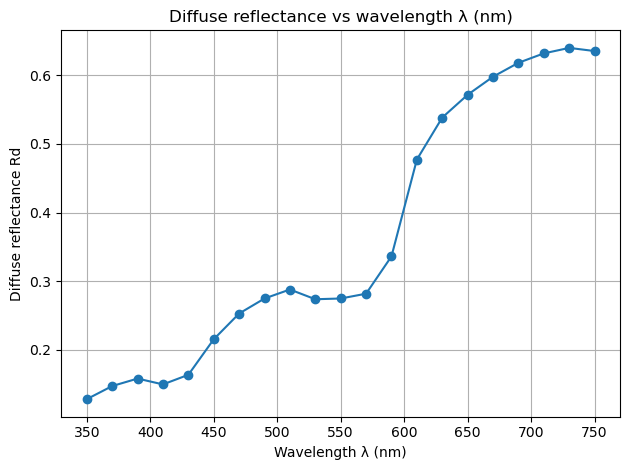

Saved plot -> skinvessel_diffuse_reflectance_vs_wavelength_nm.png


In [7]:
# Convert list of tuples to array if not already
rd_results = np.array(rd_results, dtype=float)

nm_arr = rd_results[:, 0]
rd_arr = rd_results[:, 1]

plt.figure()
plt.plot(nm_arr, rd_arr, marker='o')
plt.xlabel("Wavelength λ (nm)")
plt.ylabel("Diffuse reflectance Rd")
plt.title("Diffuse reflectance vs wavelength λ (nm)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{myname}_diffuse_reflectance_vs_wavelength_nm.png", dpi=200)
plt.show()

os.chdir(spectralLIB_dir)
    
print("Saved plot ->", f"{myname}_diffuse_reflectance_vs_wavelength_nm.png")